In [60]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

import numpy as np
import os, sys
import imageio

path_txt = os.path.join('dataset', 'train', 'gt')
path_mask = os.path.join('dataset', 'train', 'mask')

dirs_txt = os.listdir(path_txt)
dirs_mask = os.listdir(path_mask)

data = dict()

for gt in dirs_txt:
    with open(os.path.join(path_txt, gt)) as f:
        lines = f.readlines()
        
        im_name = gt.replace('gt', 'mask').replace('txt', 'png')
        im_open = (imageio.imread(os.path.join(path_mask, im_name)))

        lista = list()
        for l in lines:
            tly, tlx, bry, brx, tipo = l.split(' ')  
            tly, tlx, bry, brx = map(float, [tly, tlx, bry, brx])
            d = dict()
            d['type'] = tipo.strip()
            
            w = brx - tlx
            h = bry - tly
            
            d['width'] = w
            d['height'] = h
            d['bbox_area'] = w*h
            d['form_factor'] = w/h
            
            d['tly'] = round(tly)
            d['tlx'] = round(tlx)
            d['bry'] = round(bry)
            d['brx'] = round(brx)
            
            sub_mask = im_open[d['tly']:d['bry'], d['tlx']:d['brx']]
            mask_area = np.count_nonzero(sub_mask)
            d['mask_area'] = mask_area
            d['filling_ratio'] = mask_area / d['bbox_area']
            
            lista.append(d)
            
        data[gt] = lista
    

In [61]:
print(data['gt.00.005025.txt'][0])
print(data['gt.00.005025.txt'][1])

{'type': 'C', 'width': 52.799999999999955, 'height': 56.21000000000001, 'bbox_area': 2967.8879999999976, 'form_factor': 0.939334637964774, 'tly': 71, 'tlx': 1332, 'bry': 128, 'brx': 1385, 'mask_area': 2327, 'filling_ratio': 0.7840592367366969}
{'type': 'C', 'width': 51.299999999999955, 'height': 54.43000000000001, 'bbox_area': 2792.2589999999977, 'form_factor': 0.9424949476391686, 'tly': 146, 'tlx': 1324, 'bry': 201, 'brx': 1375, 'mask_area': 2179, 'filling_ratio': 0.7803717348569749}


In [44]:
for mask in dirs_mask:
    gt = mask.replace('mask', 'gt').replace('png', 'txt')
    m = (imageio.imread(os.path.join(path_mask, mask)))
    mask_area = m.sum()
    d = data[gt]
    d['mask_area'] = mask_area
    d['filling_ratio'] = mask_area / d['bbox_area']
    
    print(d['mask_area'], d['filling_ratio'], mask)
    

TypeError: list indices must be integers or slices, not str

In [33]:
print(dirs_mask[0].replace('mask', 'gt').replace('png', 'txt'))
print(dirs_txt[0])


gt.00.000948.txt
gt.00.005413.txt


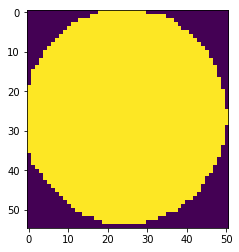

In [58]:
import matplotlib.pyplot as plt

% matplotlib inline

m = imageio.imread(os.path.join(path_mask,'mask.00.005025.png')).astype(np.int8)

plt.imshow(m[146:201, 1324:1375])


146:201, 1324-1375